# Radial Density Profile 

Here, we derive the $p(R|M_{vir},z)$ for the Buzzard v2.0

In [1]:
from astropy.table import Table, vstack
from astropy.io.fits import getdata
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(color_codes=True)
plt.rcParams.update({'font.size': 16})
sns.set_style("whitegrid")
sns.set_context("notebook",font_scale=1.3)

In [3]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")
from main import copacabana
from make_input_files import load_copa_input_catalog

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
root = '/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/'
cfg  = root+'config_buzzard_v2.yaml'

copa = copacabana(cfg,dataset='buzzard_v2')

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00000.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00016.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00017.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00018.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00019.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00020.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00022.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00032.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00034.hdf5
/data/des61.a/data/johnny

In [5]:
runs=['gauss001_r200_02Lstar','gauss003_r200_02Lstar','gauss005_r200_02Lstar']
gal = copa.load_copa_out('members',runs[0])
cat = copa.load_copa_out('cluster',runs[0])

In [6]:
g = gal[gal['True']]

In [7]:
gcid = np.array(g['CID'])
r200 = np.array(g['R200'])
zcls = np.array(g['redshift'])

#m200 = gal['M200_true']

In [8]:
radii = np.array(g['R'])

In [9]:
def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [10]:
ccid = np.array(cat['CID'])
cm200= np.array(cat['M200_true'])
cr200= np.array(cat['R200_true'])
czcls= np.array(cat['redshift'])

keys    = list(chunks(gcid,ccid))
indices = np.hstack(keys)

indices_into_cls = np.hstack([np.full(ix.size,i,dtype=int) for i,ix in enumerate(keys)])

In [11]:
keys[:2]

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87])]

In [12]:
indices

array([    0,     1,     2, ..., 92435, 92436, 92437])

In [13]:
indices_into_cls

array([   0,    0,    0, ..., 2747, 2747, 2747])

# 1. Derive Buzzard Radial Profiles

In [14]:
def _profileNFW(R,R200,c=3):
    #Radial NFW profile implementation. Takes array of radii, value of R200,
    #and NFW concentration parameter (set to 3 by default)
    if R200>0:
        Rs=float(R200)/c
        r=R/Rs
        r=np.where(np.logical_or(r<=1e-5,r==1.),r+0.001,r)
        pre=1./((r**2)-1)
        arctan_coeff=2./(np.sqrt(np.abs(r**2-1)))
        arctan_arg=np.sqrt(np.abs((r-1)/(r+1)))
        sigma=np.where(r>1,pre*(1-arctan_coeff*np.arctan(arctan_arg)),pre*(1-arctan_coeff*np.arctanh(arctan_arg)))
        
        return sigma*2*Rs
    
    else:
        bogusval=-99.*np.ones_like(R)
        return bogusval
    
def profileNFW(radii,R200,c=3,rc=0.2):
    density = _profileNFW(radii,R200,c=c) ## without norm
    #density = np.where(radii<rc,np.min(density[radii<rc]), density)
    norm    = 2*np.pi*np.trapz(radii*density,x=radii)
    return density/norm


In [15]:
def get_radial_pdf(rvec,radii,weights,rc=0.01):
    #ng  = np.histogram(radii,weights=weights,bins=rvec)[0]
    #ng  = np.array([np.sum(weights[radii<=ri]) for ri in rvec])/(np.pi*rvec**2) ## number of galaxies (<R) 
    rvec=np.where(rvec<rc,rc,rvec)
    ng    = np.full(rvec.size,0.)
    ng_var= np.full(rvec.size,0.)
    
    for i,ri in enumerate(rvec):
        mask = radii<=ri
        if np.count_nonzero(mask)>0:
            count     = np.sum(weights[mask])
            ng[i]     = count/(np.pi*ri**2)
            ng_var[i] = 1/np.sqrt(ng[i])
            
    norm= 2*np.pi*np.trapz(ng*rvec,x=rvec)
    return ng/norm

In [16]:
m200 = cm200[indices_into_cls]
zcls = czcls[indices_into_cls]

In [17]:
values = np.ones_like(radii)
rnorm  = radii/r200

rvec   = np.logspace(np.log10(0.0075),np.log10(1.),30)
#rvec   = np.linspace(0.01/2,1.,30)

In [18]:
rvec

array([0.0075    , 0.00887841, 0.01051015, 0.01244178, 0.01472842,
       0.01743532, 0.02063972, 0.02443304, 0.02892353, 0.03423931,
       0.04053207, 0.04798135, 0.05679973, 0.06723881, 0.07959646,
       0.0942253 , 0.11154273, 0.13204289, 0.15631072, 0.18503867,
       0.21904647, 0.25930447, 0.30696139, 0.36337706, 0.43016122,
       0.50921947, 0.60280764, 0.71359615, 0.84474621, 1.        ])

In [19]:
ix = keys[5]
get_radial_pdf(rvec,rnorm[ix],values[ix],rc=0.15)

array([2.66777019, 2.66777019, 2.66777019, 2.66777019, 2.66777019,
       2.66777019, 2.66777019, 2.66777019, 2.66777019, 2.66777019,
       2.66777019, 2.66777019, 2.66777019, 2.66777019, 2.66777019,
       2.66777019, 2.66777019, 2.66777019, 2.45670734, 1.783853  ,
       1.31684549, 0.98668067, 0.74879576, 0.58218892, 0.4439031 ,
       0.3451954 , 0.26371812, 0.21507227, 0.16380477, 0.13058033])

In [20]:
pdfr = get_radial_pdf(rvec,rnorm[ix],values[ix],rc=0.01)

In [21]:
def plot_radial_profile(ax,pdfr,c=None,ls='-'):
    norm = 2*np.pi*np.trapz(pdfr[0]*rvec,x=rvec)
    ax.plot(rvec,pdfr[0]/norm,color=c,ls=ls)
    ax.fill_between(rvec, pdfr[1]/norm,pdfr[2]/norm, alpha=0.2,color=c)

def plot_radial_profile_ratio(ax,pdfr,pdfr2,c=None,ls='-'):
    ax.plot(rvec,pdfr[0]/pdfr2[0],color=c,ls=ls)
    #ax.fill_between(rvec, pdfr[1],pdfr[2], alpha=0.2,color=c)


Text(0.5,0,'$R/R_{200}$')

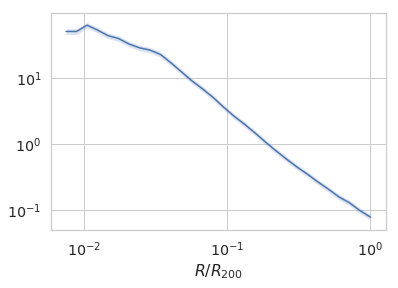

In [22]:
ax = plt.axes()
plot_radial_profile(ax,[pdfr,0.9*pdfr,1.1*pdfr])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$R/R_{200}$')

### 1.1 Bins of Mass

In [23]:
def get_bins(xbins,x):
    indices = []
    xmed    = 0.5*(xbins[1:]+xbins[:-1])
    for xl,xh in zip(xbins[:-1],xbins[1:]):
        w, = np.where((x>=xl)&(x<=xh))
        indices.append(w)
    return indices, xmed

In [24]:
def get_profile_var(x):
    w, = np.where(x[:,0]>0)
    return np.std(x[w],axis=0)

In [25]:
mbins = np.logspace(np.min(np.log10(m200)),np.max(np.log10(m200)),6)

In [26]:
mbins

array([5.00199680e+13, 9.53346788e+13, 1.81701455e+14, 3.46310695e+14,
       6.60044782e+14, 1.25800075e+15])

In [27]:
mkeys, mmed = get_bins(mbins,cm200)

In [28]:
zbins = np.linspace(0.1,0.6,11)
zkeys, zmed = get_bins(zbins,czcls)

In [29]:
profiles    = np.array([get_radial_pdf(rvec*r200[ix][0],radii[ix],values[ix],rc=0.0001) for ix in keys])
mprofiles   = [[np.mean(profiles[ii],axis=0),np.percentile(profiles[ii],16,axis=0),np.percentile(profiles[ii],84,axis=0)] for ii in mkeys]
zprofiles   = [[np.mean(profiles[ii],axis=0),np.percentile(profiles[ii],16,axis=0),np.percentile(profiles[ii],84,axis=0)] for ii in zkeys]

In [30]:
profilesNFW  = np.array([profileNFW(rvec*r200[ix][0],r200[ix][0],rc=0.01) for ix in keys])
mprofilesNFW = [[np.mean(profilesNFW[ii],axis=0),np.percentile(profilesNFW[ii],16,axis=0),np.percentile(profilesNFW[ii],84,axis=0)] for ii in mkeys]
zprofilesNFW = [[np.mean(profilesNFW[ii],axis=0),np.percentile(profilesNFW[ii],16,axis=0),np.percentile(profilesNFW[ii],84,axis=0)] for ii in zkeys]

In [31]:
colors = np.flip(np.array(sns.color_palette('copper',6)),0)

In [32]:
def plot_radial_profile_ratio(ax,pdfr,pdfr2,c=None,ls='-'):
    ax.plot(rvec,pdfr[0]/pdfr2[0],color=c,ls=ls)
    ax.fill_between(rvec, pdfr[1]/pdfr2[0],pdfr[2]/pdfr2[0], alpha=0.2,color=c)


In [33]:
prob_label = r'$p(R|M_{200})$'
ratio_label = r'ratio: Buzzard/NFW'

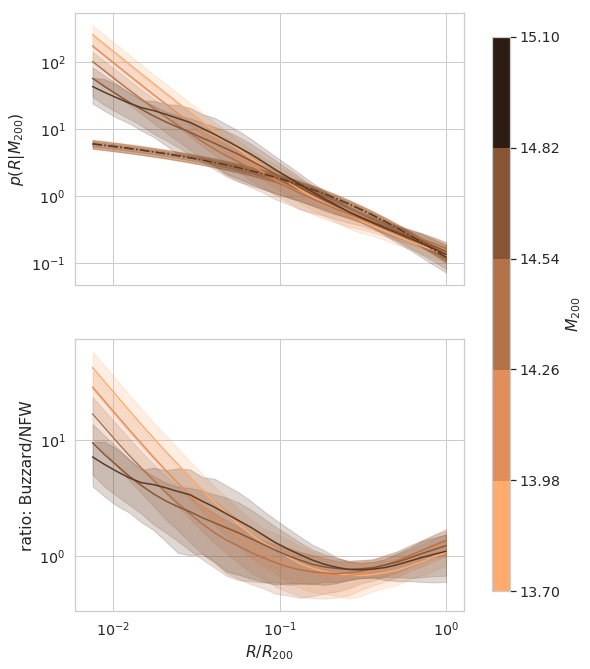

In [34]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(8, 11))

for pdfr,pdfrnfw,ci in zip(mprofiles,mprofilesNFW,colors):
    plot_radial_profile(ax1,pdfr,c=ci)
    plot_radial_profile(ax1,pdfrnfw,c=ci,ls='-.')
    plot_radial_profile_ratio(ax2,pdfr,pdfrnfw,c=ci)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(prob_label)
ax2.set_ylabel(ratio_label)
ax2.set_xlabel(r'$R/R_{200}$')

lcmap = matplotlib.colors.ListedColormap(colors)
bounds = np.log10(mbins)
norm = matplotlib.colors.BoundaryNorm(bounds, lcmap.N)

im = plt.scatter(np.zeros(5),np.zeros(5),c=np.log10(mmed),cmap=lcmap,norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$M_{200}$')
#cbar = plt.colorbar()

### 1.2 Bins of Redshift

In [35]:
colors2 = np.array(sns.color_palette("rocket_r"))#[:11]

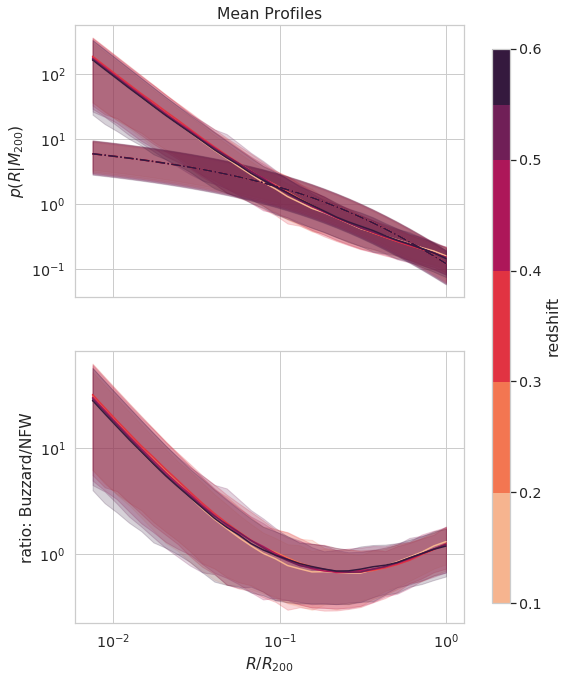

In [36]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(8, 11))

for pdfr,pdfrnfw,ci in zip(zprofiles,zprofilesNFW,colors2):
    plot_radial_profile(ax1,pdfr,c=ci)
    plot_radial_profile(ax1,pdfrnfw,c=ci,ls='-.')
    plot_radial_profile_ratio(ax2,pdfr,pdfrnfw,c=ci)

ax1.set_title('Mean Profiles')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(prob_label)
ax2.set_ylabel(ratio_label)
ax2.set_xlabel(r'$R/R_{200}$')

lcmap = matplotlib.colors.ListedColormap(colors2)
bounds = zbins
norm = matplotlib.colors.BoundaryNorm(bounds, lcmap.N)

im = plt.scatter(np.zeros(10),np.zeros(10),c=zmed,cmap=lcmap,norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'redshift')
#cbar = plt.colorbar()


# 2. Fit Buzzard Radial Profiles

In this section, I try to fit an Einasto and NFW profile.

The Einasto profile:
$$
\rho(r) = \rho_s \exp{\left( -\frac{2}{\alpha}\left[\left(\frac{r}{r_s}\right)^\alpha -1\right] \right) }
$$

The NFW profile
$$
\rho(r) = \frac{\rho_s}{\frac{r}{r_s} \left(1+\frac{r}{r_s}\right)^{2}}
$$

And the Diemer & Kravtsov 2014 density profile
$$
\rho(r) = \rho_{einasto} \times f_{trans} + \rho_{outer}
$$
where,
$$
f_{trans} = \left[\left(\frac{r}{r_t}\right)^{\beta} +1\right]^{-\frac{\gamma}{\beta}}
$$

In [37]:
#!pip install --user colossus

In [38]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');

from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_dk14

In [39]:
ii = np.argmin(np.abs(cm200-np.median(cm200)))
Mvir = cm200[ii]*0.7
cvir = 3.0
z    = czcls[ii]

In [40]:
r = rvec*cr200[ii]*1e3

In [41]:
print(np.round(r,1))

[   9.4   11.2   13.2   15.7   18.5   22.    26.    30.8   36.4   43.1
   51.    60.4   71.5   84.7  100.2  118.6  140.4  166.3  196.8  233.
  275.8  326.5  386.5  457.5  541.6  641.2  759.   898.5 1063.6 1259.1]


In [42]:
np.log10(Mvir)

14.100370542706205

In [43]:
rho_m = cosmo.rho_m(z)

p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_dk14 = profile_dk14.DK14Profile(M = Mvir, c = cvir, z = z, mdef = 'vir')

rho_nfw = p_nfw.density(r)
rho_einasto = p_einasto.density(r)
rho_dk14 = p_dk14.density(r)

Sigma_nfw = p_nfw.surfaceDensity(r)
Sigma_einasto = p_einasto.surfaceDensity(r)
Sigma_dk14 = p_dk14.surfaceDensity(r)

In [44]:
Rvir_nfw = p_nfw.RDelta(z, 'vir')
print(p_nfw.par)
rs = p_nfw.par['rs']

OrderedDict([('rhos', 628694.4276404522), ('rs', 292.6539101116021)])


In [45]:
print(p_dk14.par)

OrderedDict([('rhos', 160901.15520164563), ('rs', 292.6539101116021), ('rt', 1483.5929417472898), ('alpha', 0.2013831570168779), ('beta', 4.0), ('gamma', 8.0)])


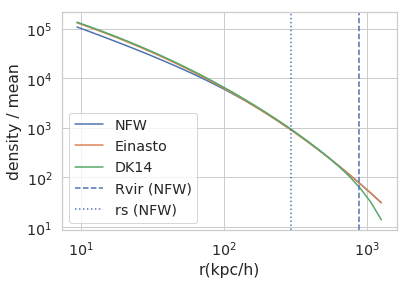

In [46]:
plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.plot(r, rho_einasto / rho_m, '-', label = 'Einasto');
plt.plot(r, rho_dk14 / rho_m, '-', label = 'DK14');
plt.axvline(Rvir_nfw, ls = '--', label = 'Rvir (NFW)');
plt.axvline(rs, ls = ':', label = 'rs (NFW)');
#plt.ylim(1E0, 1E7)
plt.legend();

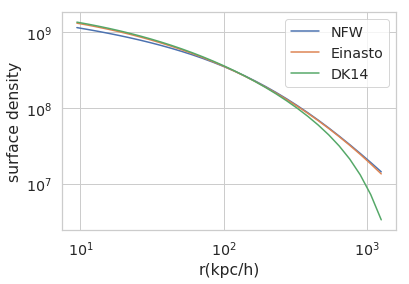

In [47]:
plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('surface density')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');
plt.plot(r, Sigma_einasto, '-', label = 'Einasto');
plt.plot(r, Sigma_dk14, '-', label = 'DK14');
plt.legend();

In [48]:
#p = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = 0.0, mdef = 'vir')
#p = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = zmed[0], mdef = 'vir')


In [49]:
p          = profile_dk14.DK14Profile(M = Mvir, c = cvir, z = z, mdef = 'vir')
sigma_true = p.surfaceDensity(r)

mask = np.array([True, True,True,True,False,False])
#mask = np.array([True, True,True])
x_true = p.getParameterArray(mask)
ini_guess = x_true

p.setParameterArray(ini_guess, mask = mask)
sigma_ini = p.surfaceDensity(r)

In [50]:
pmean, plo, pup = zprofiles[0]
psig = (pup-plo)/2.

convert_to_sigma = 2*np.pi*np.trapz(sigma_true*r,x=r)
norm             = 2*np.pi*np.trapz(pmean*r,x=r)

In [51]:
A = convert_to_sigma/norm

dict = p.fit(r, pmean*A, 'Sigma', q_err = psig*A, mask = mask)
sigma_fit = dict['q_fit']

-------------------------------------------------------------------------------------
Profile fit: Varying 4 / 6 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 352 steps. Best-fit parameters:
Parameter       rhos = 3.02e+03 [2.05e+03 .. 3.98e+03]
Parameter         rs = 1.19e+03 [1.03e+03 .. 1.36e+03]
Parameter         rt = 1.29e+09 [-3.91e+13 .. 3.91e+13]
Parameter      alpha = -1.10e-01 [-1.15e-01 .. -1.05e-01]
chi2 / Ndof = 0.2 / 26 = 0.01
-------------------------------------------------------------------------------------


In [52]:
p.par

OrderedDict([('rhos', 3015.5044054804994),
             ('rs', 1194.253446262209),
             ('rt', 1285120857.706071),
             ('alpha', -0.11017858618714116),
             ('beta', 4.0),
             ('gamma', 8.0)])

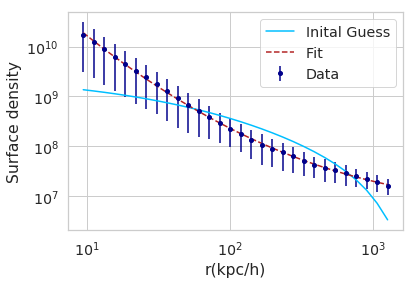

In [53]:
plt.figure()
plt.loglog()

plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'Inital Guess')
plt.errorbar(r, pmean*A, yerr = psig*A, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
plt.plot(r, sigma_fit, '--', color = 'firebrick', lw = 1.5, label = 'Fit')

plt.legend()

In [54]:
p.par

OrderedDict([('rhos', 3015.5044054804994),
             ('rs', 1194.253446262209),
             ('rt', 1285120857.706071),
             ('alpha', -0.11017858618714116),
             ('beta', 4.0),
             ('gamma', 8.0)])

In [55]:
help(profile_dk14.DK14Profile)

Help on class DK14Profile in module colossus.halo.profile_dk14:

class DK14Profile(colossus.halo.profile_base.HaloDensityProfile)
 |  The Diemer & Kravtsov 2014 density profile.
 |  
 |  The redshift must always be passed to this constructor, regardless of whether the 
 |  fundamental parameters or a mass and concentration are given.
 |  
 |  Parameters
 |  -----------------------------------------------------------------------------------------------
 |  rhos: float
 |          The central scale density, in physical :math:`M_{\odot} h^2 / {\rm kpc}^3`.
 |  rs: float
 |          The scale radius in physical kpc/h.
 |  rt: float
 |          The radius where the profile steepens, in physical kpc/h.
 |  alpha: float
 |          Determines how quickly the slope of the inner Einasto profile steepens.
 |  beta: float
 |          Sharpness of the steepening.
 |  gamma: float
 |          Asymptotic negative slope of the steepening term.
 |  M: float
 |          Halo mass in :math:`M_{\odot}/h`

In [56]:
def get_profile_DK14(pars,r200,m200,z):
    cvir    = 3
    rmpc    = r200*rvec #Mpc/h
    rkpc    = rmpc*1e3  #kpc/h
    
    inpars  = pars+[m200,cvir,'vir',z]
    profDK14= profile_dk14.DK14Profile(*inpars)
    prof    = profDK14.surfaceDensity(rkpc)
    prof_n  = prof/(2*np.pi*np.trapz(prof*rmpc,x=rmpc))     
    return prof_n

In [58]:
pars = p.par.values()

In [59]:
profilesDK14  = np.array([get_profile_DK14(pars,cr200[i],cm200[i],czcls[i]) for i,ix in enumerate(keys)])
mprofilesDK14 = [[np.mean(profilesDK14[ii],axis=0),np.percentile(profilesDK14[ii],16,axis=0),np.percentile(profilesDK14[ii],84,axis=0)] for ii in mkeys]
zprofilesDK14 = [[np.mean(profilesDK14[ii],axis=0),np.percentile(profilesDK14[ii],16,axis=0),np.percentile(profilesDK14[ii],84,axis=0)] for ii in zkeys]

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/s1/jesteves/.local/lib/python2.7/site-packages/colossus/halo/profile_base.py:475: RuntimeWarning: overflow encountered in double_scalars
  return density_function(r) * 4.0 * np.pi * r**2


In [60]:
# plt.figure()
# plt.loglog()

# plt.xlabel('r(kpc/h)')
# plt.ylabel(prob_label)
# #plt.plot(r, sigma_true/convert_to_sigma, '-', color = 'deepskyblue', label = 'Inital Guess')

# plt.errorbar(r/cr200[ii], pmean/norm, yerr = psig/norm, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
# plt.plot(r/cr200[ii], rec_p.surfaceDensity(r)/convert_to_sigma, '--', color = 'firebrick', lw = 1.5, label = 'DK14 Fit')

# plt.legend()

In [61]:
p.par

OrderedDict([('rhos', 3015.5044054804994),
             ('rs', 1194.253446262209),
             ('rt', 1285120857.706071),
             ('alpha', -0.11017858618714116),
             ('beta', 4.0),
             ('gamma', 8.0)])

In [62]:
pars = p.par.values()+[cm200[ii],3,'vir',zmed[0]]

In [63]:
rec_p = profile_dk14.DK14Profile(*pars)

In [64]:
buzzardPR = rec_p.surfaceDensity(r)
buzzardPR /= 2*np.pi*np.trapz(buzzardPR*rvec,x=rvec)

In [65]:
prob_label = r'$p(R|M_{200})$'
ratio_label = r'ratio: Buzzard/DK 14'

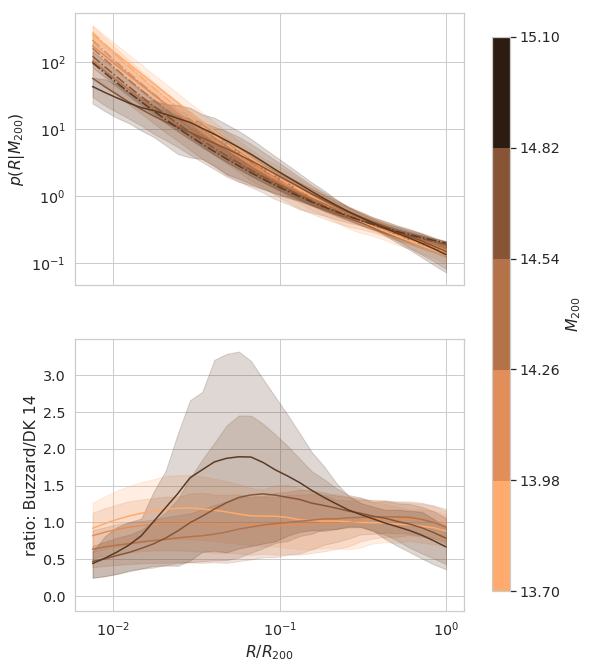

In [66]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(8, 11))

#ax1.loglog()
i=0
for pdfr,pdfrdk14,ci in zip(mprofiles,mprofilesDK14,colors):
    plot_radial_profile(ax1,pdfr,c=ci)
    plot_radial_profile(ax1,pdfrdk14,c=ci,ls='-.')
    plot_radial_profile_ratio(ax2,pdfr,pdfrdk14,c=ci)
    #plot_radial_profile_ratio(ax2,pdfr,[buzzardPR],c=ci)
    #ax1.plot(rvec, profilesDK14[i], '--', color = ci, lw = 3.5, label = 'DK14 Fit')
    i+=1

#ax1.plot(rvec, buzzardPR*(1.03), '--', color = 'k', lw = 3.5, label = 'DK14 Fit')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(prob_label)
ax2.set_ylabel(ratio_label)
ax2.set_xlabel(r'$R/R_{200}$')

lcmap = matplotlib.colors.ListedColormap(colors)
bounds = np.log10(mbins)
norm = matplotlib.colors.BoundaryNorm(bounds, lcmap.N)

im = plt.scatter(np.zeros(5),np.zeros(5),c=np.log10(mmed),cmap=lcmap,norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$M_{200}$')
#cbar = plt.colorbar()